In [1]:
## importing the necessary dependencies

import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib

from obspy.geodetics.base import gps2dist_azimuth
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import tsfel

## for location
from obspy.geodetics.base import gps2dist_azimuth


## K Fold cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
#from tsfresh import extract_features
#from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
import time

In [2]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['font.weight'] = 'bold'

In [3]:
iq_lats = pd.read_csv('../Catalogs/icequakes_catalog.csv')['latitude']
iq_lons = pd.read_csv('../Catalogs/icequakes_catalog.csv')['longitude']

eq_lats = pd.read_csv('../Catalogs/earthquakes_catalog.csv')['latitude']
eq_lons = pd.read_csv('../Catalogs/earthquakes_catalog.csv')['longitude']

stns = pd.read_csv('../Catalogs/gmap-stations.txt', sep='|', skiprows=[2,6])


stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278

no_of_icequakes = []
no_of_earthquakes = []
for i in range(15):
    no_of_icequakes.append(len(glob('../Data/icequake_waveforms/*'+stations[i]+'*')))
    no_of_earthquakes.append(len(glob('../Data/earthquake_waveforms/*'+stations[i]+'*')))
    
    
total_events = np.array(no_of_icequakes)+np.array(no_of_earthquakes)
order = np.argsort(total_events)

In [4]:
## Initialize model 


## Ok following function is going to iterate 10 times. With each iteration, we are going to get all the misclassified 
# events. After 10 iterations, we are going to flatten the array and save it in the miss_iq_all for icequakes
# then we are going to store all the misclassified events in 10 iterations for each station. 
# In every iteration, we are randomly splitting the data into three folds. 
# This ensures that there is a almost equal number of icequakes and earthquakes within each fold. 


# defining a model with default configuration. 
model = RandomForestClassifier(n_estimators = 100)

# initializing the misclassified events list. 
miss_iq_stations = []
miss_eq_stations = []
miss_iq_probs_stations = []
miss_eq_probs_stations = []


miss_iq_all = []
miss_eq_all = []
miss_iq_probs_all = []
miss_eq_probs_all = []



for station in tqdm(stations):
    ## Initialize data
    X1 = pd.read_csv(glob("/home/ak287/Icequakes_vs_Tectonicquakes/tsfel_raw_data_features/all/30s/"+station+".csv")[0])
    y1 = np.loadtxt("/home/ak287/Icequakes_vs_Tectonicquakes/tsfel_raw_data_features/all/30s/"+station+"_labels.txt")
    X1['label'] = y1

    X = np.array(X1)
    y = np.array(y1)

    ## Perform three fold cross validation
    miss_iq = []
    miss_eq = []
    miss_iq_probs = []
    miss_eq_probs = []


    for j in range(10):

        #print(f"iteration no. {j}")

        kf = KFold(n_splits = 3, random_state = 10, shuffle = True) 


        for fold, (train_indices, test_indices) in enumerate(kf.split(X)):
            X_train, y_train = X[train_indices], y[train_indices]
            #print(f"Training data {len(train_indices)}, No_of_Icequakes: {len(y_train[y_train == 1])}, No_of_earthquakes: {len(y_train[y_train == 0])}")

            X_test, y_test = X[test_indices], y[test_indices]
            #print(f"Training data {len(test_indices)}, No_of_Icequakes: {len(y_test[y_test == 1])}, No_of_earthquakes: {len(y_test[y_test == 0])}")



            model.fit(X_train[:,1:391], y_train)
            y_pred = model.predict(X_test[:,1:391])
            y_probs = model.predict_proba(X_test[:, 1:391])

            miss = pd.DataFrame(X_test[y_test != y_pred][:,[0,-2, -1]])
            miss_probs = pd.DataFrame(y_probs)[y_test != y_pred]
            
            miss_iq.append(miss[miss[2] == 1][1].values)
            miss_eq.append(miss[miss[2] == 0][1].values)

            miss_iq_probs.append(miss_probs.reset_index(drop=True)[miss[2] == 1])
            miss_eq_probs.append(miss_probs.reset_index(drop=True)[miss[2] == 0])
            
            
            ## calculate accuracy and identify misclassifications. 
            accuracy = accuracy_score(y_test, y_pred)
            misclassifications = [(i, y_true, y_pred) for i, (y_true, y_pred) in enumerate(zip(y_test, y_pred)) if y_true!= y_pred]

            ## Print results for this fold 

            ## Note the printing syntax, you can insert a value after {}
            #print(f"Fold {fold}: Accuracy = {accuracy:.2f}, Misclassifications = {len(misclassifications)}")

    miss_iq_all = np.concatenate(miss_iq)
    miss_iq_probs_all = np.concatenate(miss_iq_probs)
    
    miss_eq_all = np.concatenate(miss_eq)
    miss_eq_probs_all = np.concatenate(miss_eq_probs)
    
    miss_iq_probs_stations.append(miss_iq_probs_all)
    miss_eq_probs_stations.append(miss_eq_probs_all)
    
    
    miss_iq_stations.append(miss_iq_all)
    miss_eq_stations.append(miss_eq_all)
    
    ## miss_iq_stations contains all the icequakes that were misclassified in 10 iterations.Same holds for miss_eq_stations. 


100%|██████████| 15/15 [06:44<00:00, 27.00s/it]


In [5]:
## 1 is for icequakes and 0 is for earthquakes

In [7]:
miss_iq_stations[0]

array([ 156.,  150.,  163.,  297.,  331.,  378.,  156.,   55.,  150.,
        297.,  331.,  378.,  156.,   55.,  150.,  163.,  331.,  378.,
        134.,  156.,   55.,  150.,  163.,  297.,  331.,  378.,  156.,
        150.,  331.,  378.,  156.,  150.,  163.,  297.,  331.,  378.,
        156.,   55.,  150.,  331.,  378.,  134.,  156.,  150.,  163.,
        297.,  331.,  378.,  156.,   55.,  150.,  163.,  297.,  331.,
        378.,  156.,   55.,  138.,  150.,  163.,  331.,  378.])

## Analysing Missclassified Icequakes

In [8]:
## Now we are going to store all those missclassified events that were present in atleast 50% of iterations 
# that quantifies the confidence

evstns_iq = []
evcounts_iq = []
miss_probs_iq = []

for i in range(len(stations)):
    
    
    df = pd.DataFrame([])
    df['Event_ID'] = miss_iq_stations[i].astype('int')
    df['Missclass_Prob'] = miss_iq_probs_stations[i][:,0]
    df.index = df['Event_ID']
    df = df.drop('Event_ID', axis = 1)
    df_avg = df.groupby('Event_ID').mean()
    
    evids, counts = np.unique(miss_iq_stations[i], return_counts = True) # to get all the missclassified events across all
    # the stations and their counts. 
    
    df_temp = df_avg.loc[evids] 
    
    miss_probs_iq.append(df_temp['Missclass_Prob'].values)
    evstns_iq.append(evids[counts/10 > 0.5])
    evcounts_iq.append(counts[counts/10 > 0.5]/10)
    
    
## So evstns stores all those events at each stations which appear more than 50% in 10 iterations. 
## evcounts stores the amount of times those events appeared in 10 iterations. 
    

In [9]:
np.unique(np.concatenate(evstns_iq)).astype('int')

array([   0,    3,    6,    7,    9,   10,   12,   14,   15,   16,   18,
         22,   23,   24,   25,   29,   31,   32,   35,   38,   40,   42,
         43,   44,   45,   48,   51,   52,   53,   54,   55,   57,   58,
         61,   63,   67,   69,   71,   72,   73,   75,   80,   81,   82,
         83,   84,   85,   87,   91,   94,   96,   99,  102,  103,  107,
        109,  110,  111,  112,  113,  114,  116,  118,  119,  121,  122,
        124,  125,  127,  129,  130,  131,  134,  143,  147,  150,  154,
        155,  156,  157,  158,  159,  161,  162,  163,  165,  166,  167,
        168,  169,  170,  174,  175,  176,  178,  180,  181,  185,  187,
        188,  189,  196,  198,  199,  200,  203,  204,  206,  207,  209,
        214,  220,  221,  222,  226,  227,  229,  230,  231,  232,  233,
        234,  237,  238,  239,  240,  242,  243,  246,  253,  255,  259,
        260,  262,  263,  271,  272,  276,  280,  281,  282,  284,  285,
        287,  294,  296,  297,  298,  300,  301,  3

In [26]:
# evstns is a list of all the misclassified events that were misclassified at each station more than 50% in 10 iterations. 
# So uids is trying to find how many events in the total were misclassified at all the stations more than 50% in 
# 10 iterations. 

uids_iq = np.unique(np.concatenate(evstns_iq)).astype('int')



whichstn_iq = []
whichcount_iq = []
for i in range(len(uids_iq)):
    # This loop is going through each of the events, searches for it in the dataframe, 
    # produces the list of rows and columns where it occurs but we are mainly concerned with 
    # the rows, because we are trying to find the stations at which a given event occurs. 
    
    whichstn_iq.append(np.where(pd.DataFrame(evstns_iq) ==  uids_iq[i])[0]) ## This guy is 
  
    #storing rows where the eventid occurs. 
    
mat = np.zeros([len(stns), len(uids_iq)])  

for i in range(len(whichstn_iq)):
            mat[whichstn_iq[i],i] = 1
        
        
# So now we have a matrix whose rows are stations and whose columns are events that were misclassified atleast 
# five out of ten times at different stations. 


df_iq = pd.DataFrame(mat)
df_iq.columns = uids_iq
df_iq.index = stations

In [27]:
del df

In [29]:
# this is storing the event ids. 
evid = df_iq.columns.values


for i in tqdm(range(len(stations))):
    stn_events = []
    for j in range(len(glob('../Data/icequake_waveforms/*'+stations[i]+'*'))):
        stn_events.append(int(glob('../Data/icequake_waveforms/*'+stations[i]+'*')[j].split('/')[-1].split('_')[0].split('icequake')[1]))

    diff = np.setdiff1d(evid, stn_events)

    for k in range(len(diff)):
        df_iq.loc[stations[i], diff[k]] = np.nan
    
    

100%|██████████| 15/15 [08:00<00:00, 32.03s/it]


In [31]:
# Assuming df is a DataFrame with event ids as columns and stations as rows

evid = df_iq.columns.values

for station in tqdm(stations):
    stn_events = {
        int(path.split('/')[-1].split('_')[0].split('icequake')[1])
        for path in glob(f'../Data/icequake_waveforms/*{station}*')
    }

    diff = set(evid) - stn_events

    # Vectorized update
    df_iq.loc[station, list(diff)] = np.nan


100%|██████████| 15/15 [00:00<00:00, 44.01it/s]


In [32]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['xtick.major.size'] = 0
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['font.weight'] = 'bold'

Text(114.0, 0.5, 'Stations')

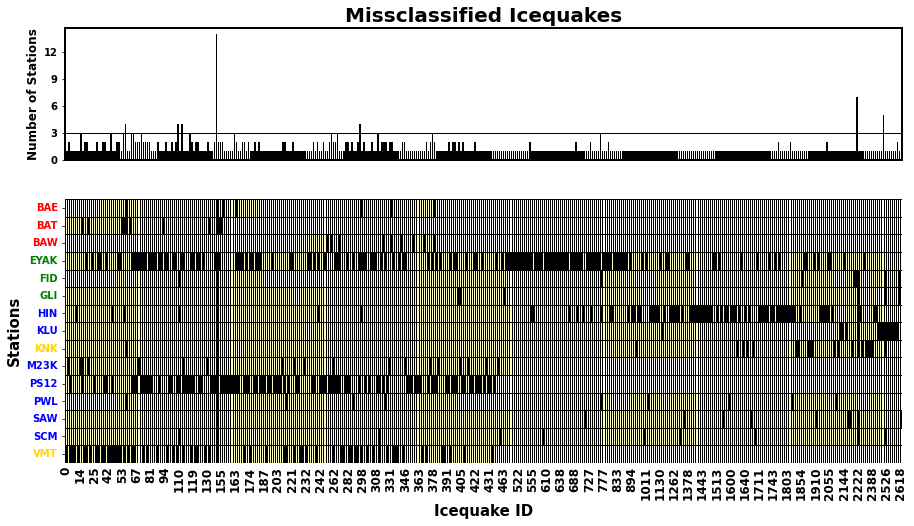

In [35]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize = [15,8])

gs = gridspec.GridSpec(2,1, height_ratios = [1,2])

# create the subplots

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax = [ax1,ax2]
ax[0].bar(np.arange(len(uids_iq)), df_iq.sum(), color = 'k')
ax[0].set_xlim(0,len(uids_iq))
ax[0].set_xticks([])
ax[0].set_yticks(np.arange(0,15,3))
ax[0].set_ylabel('Number of Stations', fontweight = 'bold', fontsize = 12)
ax[0].axhline(3, color = 'k')
ax[0].set_title('Missclassified Icequakes', fontweight = 'bold', fontsize = 20)
sns.heatmap(df_iq, cmap = 'magma_r', ax = ax[1], cbar = False, linewidth = 0.5, linecolor = 'k')


ytick_colors = ['r','r','r','g','g','g','blue','blue','gold','blue','blue','blue','blue','blue','gold']
# Set the color for each tick label individually
for i, label in enumerate(ax[1].get_yticklabels()):
       label.set_color(ytick_colors[i])
        
        
    
#plt.bar(np.arange(len(uids))[0:200], df.sum(), color = 'blue')
ax[1].set_xlabel('Icequake ID', fontsize = 15, fontweight = 'bold')
ax[1].set_ylabel('Stations',fontsize = 15, fontweight = 'bold')

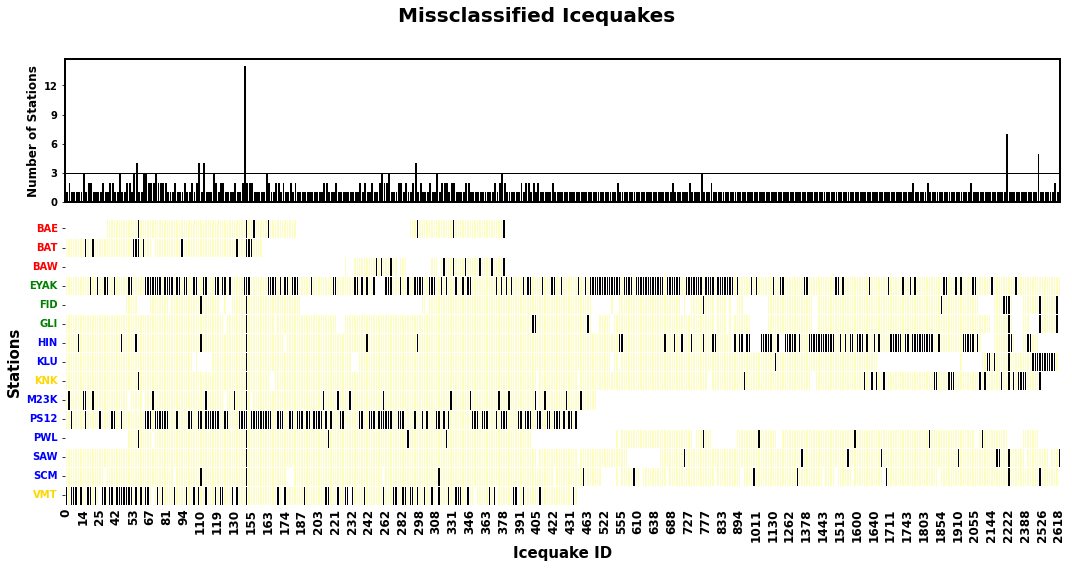

In [37]:
# Create a color map for the heatmap
cmap_heatmap = 'magma_r'

fig, ax = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [1, 2]})
fig.suptitle('Missclassified Icequakes', fontweight='bold', fontsize=20)

# Plot the bar chart
ax[0].bar(np.arange(len(uids_iq)), df_iq.sum(), color='k')
ax[0].set_xlim(0, len(uids_iq))
ax[0].set_xticks([])
ax[0].set_yticks(np.arange(0, 15, 3))
ax[0].set_ylabel('Number of Stations', fontweight='bold', fontsize=12)
ax[0].axhline(3, color='k')

# Plot the heatmap
sns.heatmap(df_iq, cmap=cmap_heatmap, ax=ax[1], cbar=False, linewidth= 0.5)

# Customize y-axis ticks and colors
ytick_colors = ['r', 'r', 'r', 'g', 'g', 'g', 'blue', 'blue', 'gold', 'blue', 'blue', 'blue', 'blue', 'blue', 'gold']
for i, label in enumerate(ax[1].get_yticklabels()):
    label.set_color(ytick_colors[i])

# Set labels for the axes
ax[1].set_xlabel('Icequake ID', fontsize=15, fontweight='bold')
ax[1].set_ylabel('Stations', fontsize=15, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title
plt.show()


In [40]:
icequakes = pd.read_csv('../Catalogs/icequakes_catalog.csv')
miss_index = df_iq.sum().iloc[np.where(df_iq.sum() >= 3)].index.values
df_miss_iq = icequakes.iloc[miss_index]
df_miss_iq['No_of_stations'] =  df_iq.sum().iloc[np.where(df_iq.sum() >= 3)].values.astype('int')

df_miss_iq.to_csv('../Catalogs/missclassified_icequakes.csv')
df_miss_iq.head()

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


time  latitude  longitude  depth  mag magType  nst  \
15  2022-02-28T20:59:02.490Z   61.1787  -146.9064    0.0  0.9      ml  NaN   
44  2022-01-25T10:09:06.645Z   61.1167  -147.2917    0.0  1.3      ml  NaN   
54  2021-12-29T13:22:40.386Z   61.3279  -147.6791    0.0  1.1      ml  NaN   
55  2021-12-26T15:48:33.256Z   61.1833  -147.0113    0.0  0.9      ml  NaN   
61  2021-12-22T22:45:27.096Z   61.1879  -147.2426    0.0  0.9      ml  NaN   

    gap  dmin   rms  ...                            place       type  \
15  NaN   NaN  0.38  ...        30 km W of Valdez, Alaska  ice quake   
44  NaN   NaN  0.30  ...     43 km NW of Tatitlek, Alaska  ice quake   
54  NaN   NaN  0.62  ...  53 km S of Glacier View, Alaska  ice quake   
55  NaN   NaN  0.75  ...        36 km W of Valdez, Alaska  ice quake   
61  NaN   NaN  0.40  ...     47 km NW of Tatitlek, Alaska  ice quake   

   horizontalError depthError magError  magNst    status  locationSource  \
15             NaN        0.0      NaN     NaN  reviewed              ak   
44             NaN        0.0      NaN     NaN  reviewed              ak   
54             NaN        0.0      NaN     NaN  reviewed              ak   
55             NaN        0.0      NaN     NaN  reviewed              ak   
61             NaN        0.0      NaN     NaN  reviewed              ak   

    magSource No_of_stations  
15         ak              3  
44         ak              3  
54         ak              3  
55         ak              4  
61         ak              3  

[5 rows x 23 columns]

In [41]:
stn_w_wf = []

wf_files = glob('../Data/icequake_waveforms/icequake150_*')
for i in range(len(wf_files)):
    stn_w_wf.append(wf_files[i].split('/')[-1].split('_')[1].split('.')[0])

def compute_epi_dist(index = 150, station = 'BAE'):

    ev_lat = icequakes.iloc[index].latitude
    ev_lon = icequakes.iloc[index].longitude
    stn_lat =  stns[stns[' Station '] == station][' Latitude '].values[0]
    stn_lon = stns[stns[' Station '] == station][' Longitude '].values[0]

    dist = gps2dist_azimuth(ev_lat, ev_lon, stn_lat, stn_lon)[0]/1000
    
    return dist

dist = []
for i in range(len(stn_w_wf)):
    dist.append(compute_epi_dist(station = stn_w_wf[i]))
    
dist_order = np.argsort(dist)
dist_order

array([13,  6,  3,  4,  9,  2,  5, 12,  0,  1,  8, 10,  7, 11])

['SAW', 'mseed']

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9

([<matplotlib.axis.YTick at 0x7fae4be2ac10>,
 [Text(0, 0, '12.28'),
  Text(0, 1, '40.92'),
  Text(0, 2, '51.89'),
  Text(0, 3, '57.71'),
  Text(0, 4, '66.49'),
  Text(0, 5, '70.71'),
  Text(0, 6, '85.5'),
  Text(0, 7, '97.74'),
  Text(0, 8, '104.55'),
  Text(0, 9, '107.31'),
  Text(0, 10, '109.3'),
  Text(0, 11, '120.71'),
  Text(0, 12, '125.59'),
  Text(0, 13, '136.09')])

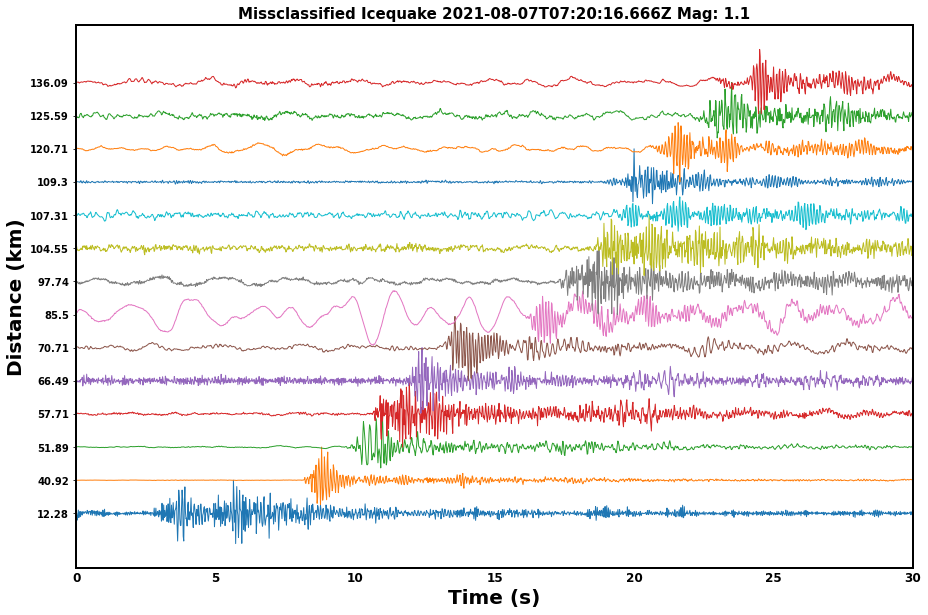

In [59]:
temp_stn = []
plt.figure(figsize = [15,10])
for i in range(len(dist_order)):
    st = obspy.read(glob('../Data/icequake_waveforms/icequake150_*')[dist_order[i]])[2]
    temp_stn.append(glob('../Data/icequake_waveforms/icequake150_*')[dist_order[i]].split('_')[-1].split('.')[0])
    st.detrend()
    st.filter('bandpass', freqmin = 0.5, freqmax = 25)

    d = st.data/np.max(abs(st.data))
    t = st.times()

     
        
    plt.plot(t,d+i, lw = 1)

    plt.xlim(0,30)

    
plt.title('Missclassified Icequake '+icequakes.iloc[150].time + ' Mag: '+str(np.around(icequakes.iloc[150].mag,2))
         , fontsize = 15, fontweight = 'bold')
plt.ylabel('Distance (km)', fontsize = 20, fontweight = 'bold')
plt.xlabel('Time (s)', fontsize = 20, fontweight = 'bold')
plt.yticks(ticks = np.arange(len(dist_order)),labels = [str(np.around(i,2)) for i in np.array(dist)[dist_order]])

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9

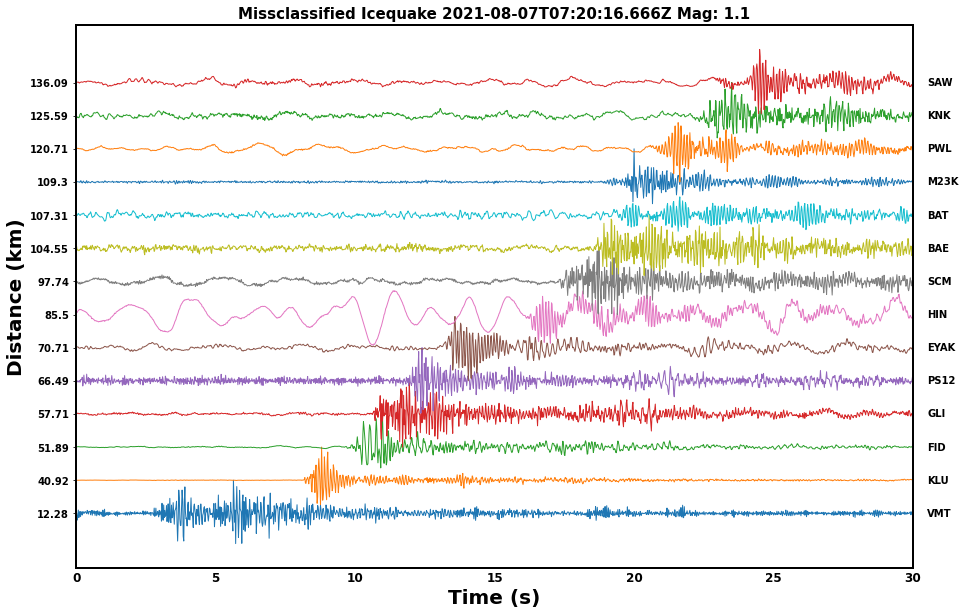

In [60]:
temp_stn = []
plt.figure(figsize=[15, 10])
for i in range(len(dist_order)):
    st = obspy.read(glob('../Data/icequake_waveforms/icequake150_*')[dist_order[i]])[2]
    temp_stn.append(glob('../Data/icequake_waveforms/icequake150_*')[dist_order[i]].split('_')[-1].split('.')[0])
    st.detrend()
    st.filter('bandpass', freqmin=0.5, freqmax=25)

    d = st.data / np.max(abs(st.data))
    t = st.times()

    plt.plot(t, d + i, lw=1)

    plt.xlim(0, 30)

# Add labels on the right-hand side of the y-axis
plt.yticks(ticks=np.arange(len(dist_order)),
           labels=[str(np.around(i, 2)) for i in np.array(dist)[dist_order]])
for i, label in enumerate(temp_stn):
    plt.text(30.5, i, label, ha='left', va='center', fontsize=10)

plt.title('Missclassified Icequake ' + icequakes.iloc[150].time + ' Mag: ' + str(np.around(icequakes.iloc[150].mag, 2)),
          fontsize=15, fontweight='bold')
plt.ylabel('Distance (km)', fontsize=20, fontweight='bold')
plt.xlabel('Time (s)', fontsize=20, fontweight='bold')
plt.show()


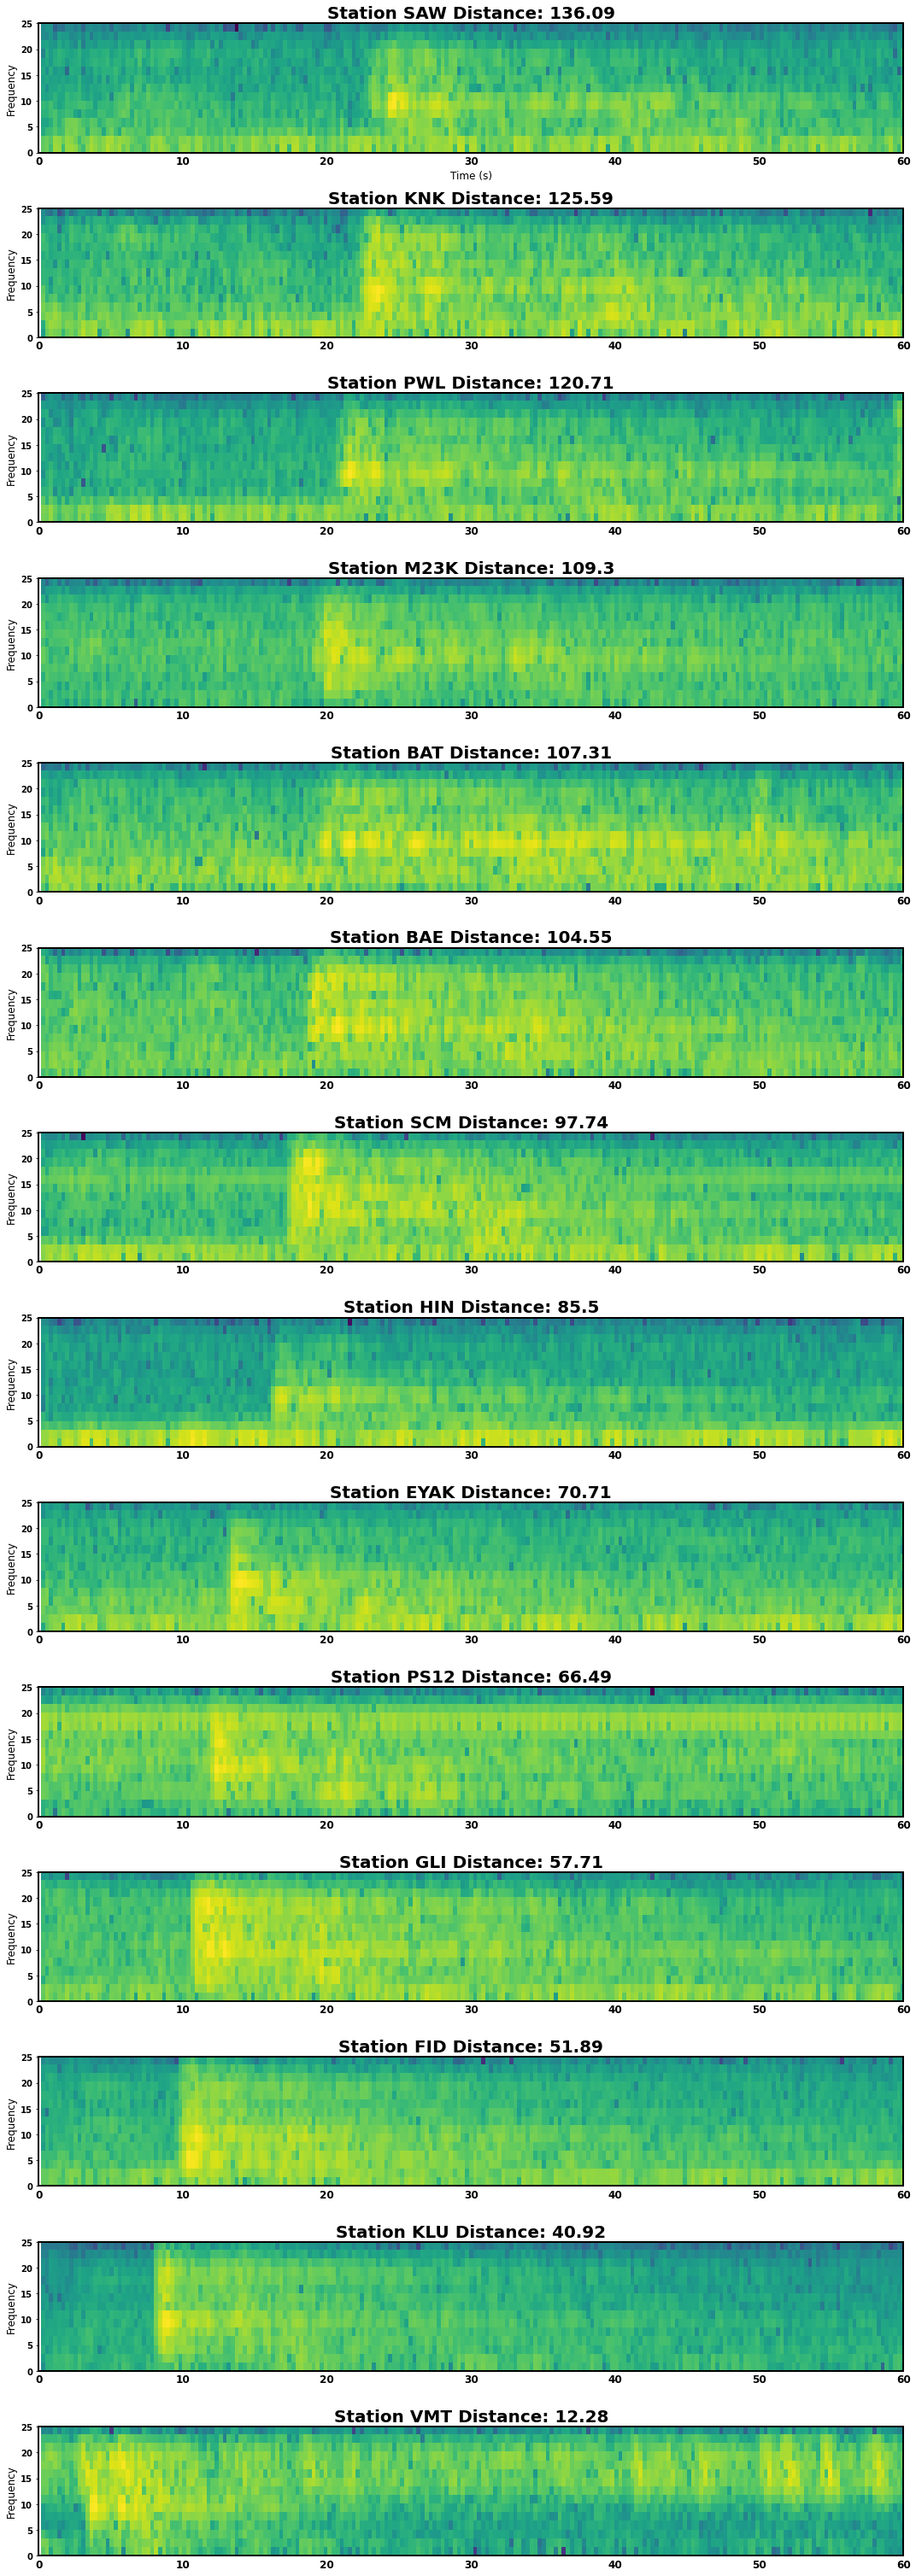

In [99]:
temp_stn = []
fig, axes = plt.subplots(len(dist_order), 1, figsize=(15, 3*len(dist_order)))

axes = axes[::-1]
for i in range(len(dist_order)):
    st = obspy.read(glob('../Data/icequake_waveforms/icequake150_*')[dist_order[i]])[2]
    temp_stn.append(glob('../Data/icequake_waveforms/icequake150_*')[dist_order[i]].split('_')[-1].split('.')[0])
    st.detrend()
    st.filter('bandpass', freqmin=0.5, freqmax=25)

    d = st.data / np.max(abs(st.data))
    t = st.times()

    # Plot spectrogram in a separate subplot
    ax = axes[i]
    ax.specgram(d, Fs=50, NFFT= 28, noverlap=  14, cmap='viridis', aspect='auto')

    # Set y-axis label for each subplot
    ax.set_ylabel('Frequency', fontsize=12)
    #ax.set_yticks([i])
    #ax.set_yticklabels([str(np.around(np.array(dist)[dist_order][i], 2))])

    # Set title for each subplot
    ax.set_title('Station ' + temp_stn[i]+' Distance: '+str(np.around(np.array(dist)[dist_order][i], 2)), fontsize=20, fontweight = 'bold')

    ax.set_xlim(0,60)
# Set common x-axis label
axes[-1].set_xlabel('Time (s)', fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


## Analysis of missclassified Earthquakes

In [144]:
## Now we are going to store all those missclassified events that were present in atleast 50% of iterations 
# that quantifies the confidence

evstns = []
evcounts = []

for i in range(len(stations)):
    evids, counts = np.unique(miss_eq_stations[i], return_counts = True) # to get all the missclassified events across all
    # the stations and their counts. 
    
    evstns.append(evids[counts/10 > 0.5])
    evcounts.append(counts[counts/10 > 0.5]/10)
    
## So evstns stores all those events at each stations which appear more than 50% in 10 iterations. 
## evcounts stores the amount of times those events appeared in 10 iterations. 
    

In [145]:
uids = np.unique(np.concatenate(evstns)).astype('int')



whichstn = []
whichcount = []
for i in range(len(uids)):
    # This loop is going through each of the events, searches for it in the dataframe, 
    # produces the list of rows and columns where it occurs but we are mainly concerned with 
    # the rows, because we are trying to find the stations at which a given event occurs. 
    
    whichstn.append(np.where(pd.DataFrame(evstns) ==  uids[i])[0]) ## This guy is 
  
    #storing rows where the eventid occurs. 
    
mat = np.zeros([len(stns), len(uids)])  

for i in range(len(whichstn)):
            mat[whichstn[i],i] = 1
        
        
# So now we have a matrix whose rows are stations and whose columns are events that were misclassified atleast 
# five out of ten times at different stations. 

df = pd.DataFrame(mat)
df.columns = uids
df.index = stations

In [146]:
evid = df.columns.values


for i in tqdm(range(len(stations))):
    stn_events = []
    for j in range(len(glob('../Data/earthquake_waveforms/*'+stations[i]+'*'))):
        stn_events.append(int(glob('../Data/earthquake_waveforms/*'+stations[i]+'*')[j].split('_')[2]))

    diff = np.setdiff1d(evid, stn_events)

    for k in range(len(diff)):
        df.loc[stations[i], diff[k]] = np.nan
    
    

100%|██████████| 15/15 [08:05<00:00, 32.40s/it]


Text(114.0, 0.5, 'Stations')

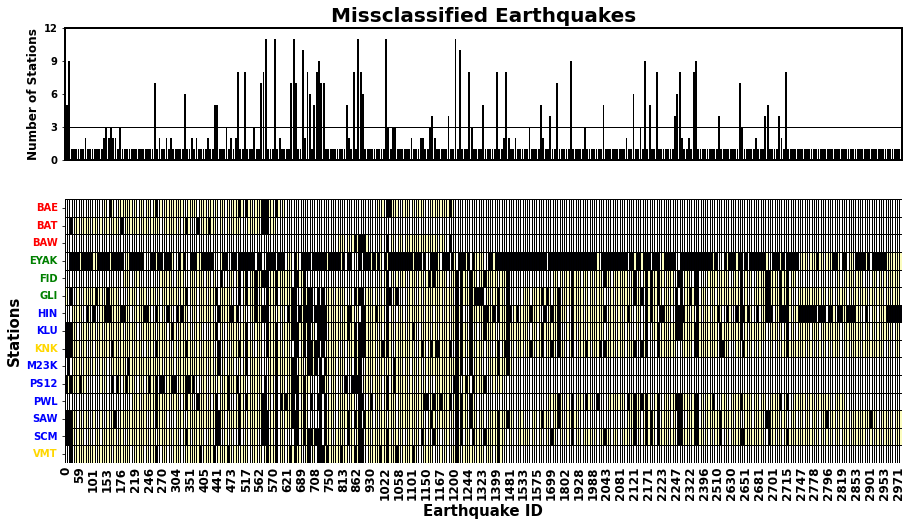

In [150]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize = [15,8])

gs = gridspec.GridSpec(2,1, height_ratios = [1,2])

# create the subplots

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax = [ax1,ax2]
ax[0].bar(np.arange(len(uids)), df.sum(), color = 'k')
ax[0].set_xlim(0,len(uids))
ax[0].set_xticks([])
ax[0].set_yticks(np.arange(0,15,3))


ax[0].set_ylabel('Number of Stations', fontweight = 'bold', fontsize = 12)
ax[0].axhline(3, color = 'k')
ax[0].set_title('Missclassified Earthquakes', fontweight = 'bold', fontsize = 20)
sns.heatmap(df, cmap = 'magma_r', ax = ax[1], cbar = False,linewidth = 0.5, linecolor = 'k')

ytick_colors = ['r','r','r','g','g','g','blue','blue','gold','blue','blue','blue','blue','blue','gold']
# Set the color for each tick label individually
for i, label in enumerate(ax[1].get_yticklabels()):
       label.set_color(ytick_colors[i])
        
#plt.bar(np.arange(len(uids))[0:200], df.sum(), color = 'blue')
ax[1].set_xlabel('Earthquake ID', fontsize = 15, fontweight = 'bold')
ax[1].set_ylabel('Stations',fontsize = 15, fontweight = 'bold')

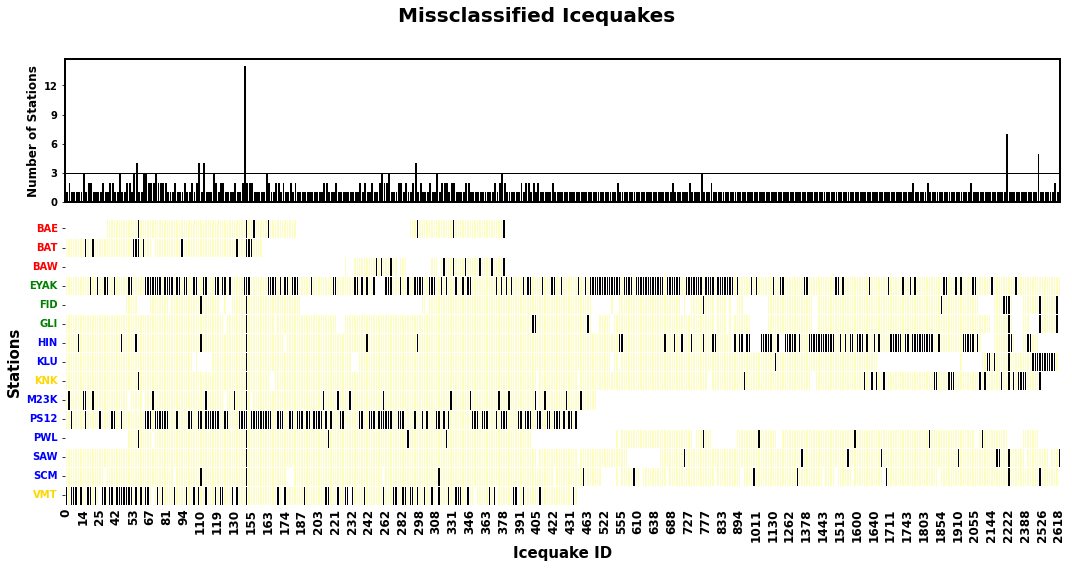

In [151]:
# Create a color map for the heatmap
cmap_heatmap = 'magma_r'

fig, ax = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [1, 2]})
fig.suptitle('Missclassified Icequakes', fontweight='bold', fontsize=20)

# Plot the bar chart
ax[0].bar(np.arange(len(uids_iq)), df_iq.sum(), color='k')
ax[0].set_xlim(0, len(uids_iq))
ax[0].set_xticks([])
ax[0].set_yticks(np.arange(0, 15, 3))
ax[0].set_ylabel('Number of Stations', fontweight='bold', fontsize=12)
ax[0].axhline(3, color='k')

# Plot the heatmap
sns.heatmap(df_iq, cmap=cmap_heatmap, ax=ax[1], cbar=False, linewidth= 0.5)

# Customize y-axis ticks and colors
ytick_colors = ['r', 'r', 'r', 'g', 'g', 'g', 'blue', 'blue', 'gold', 'blue', 'blue', 'blue', 'blue', 'blue', 'gold']
for i, label in enumerate(ax[1].get_yticklabels()):
    label.set_color(ytick_colors[i])

# Set labels for the axes
ax[1].set_xlabel('Icequake ID', fontsize=15, fontweight='bold')
ax[1].set_ylabel('Stations', fontsize=15, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title
plt.show()


Text(114.0, 0.5, 'Stations')

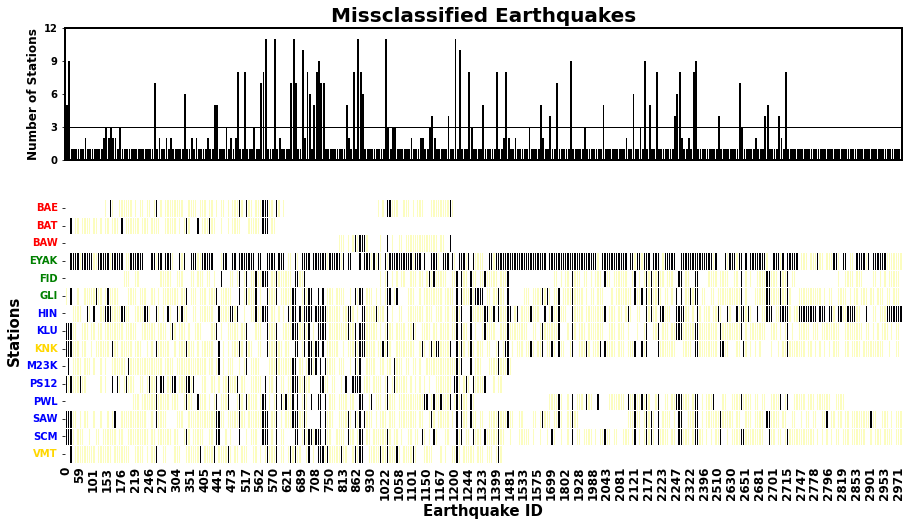

In [152]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize = [15,8])

gs = gridspec.GridSpec(2,1, height_ratios = [1,2])

# create the subplots

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax = [ax1,ax2]
ax[0].bar(np.arange(len(uids)), df.sum(), color = 'k')
ax[0].set_xlim(0,len(uids))
ax[0].set_xticks([])
ax[0].set_yticks(np.arange(0,15,3))


ax[0].set_ylabel('Number of Stations', fontweight = 'bold', fontsize = 12)
ax[0].axhline(3, color = 'k')
ax[0].set_title('Missclassified Earthquakes', fontweight = 'bold', fontsize = 20)
sns.heatmap(df, cmap = 'magma_r', ax = ax[1], cbar = False,linewidth = 0.5)

ytick_colors = ['r','r','r','g','g','g','blue','blue','gold','blue','blue','blue','blue','blue','gold']
# Set the color for each tick label individually
for i, label in enumerate(ax[1].get_yticklabels()):
       label.set_color(ytick_colors[i])
        
#plt.bar(np.arange(len(uids))[0:200], df.sum(), color = 'blue')
ax[1].set_xlabel('Earthquake ID', fontsize = 15, fontweight = 'bold')
ax[1].set_ylabel('Stations',fontsize = 15, fontweight = 'bold')

In [106]:
earthquakes = pd.read_csv('../Catalogs/earthquakes_catalog.csv')
miss_index = df.sum().iloc[np.where(df.sum() >= 3)].index.values
df_miss_eq = earthquakes.iloc[miss_index]
df_miss_eq['No_of_stations'] =  df.sum().iloc[np.where(df.sum() >= 3)].values.astype('int')

df_miss_eq.to_csv('../Catalogs/missclassified_earthquakes.csv')
df_miss_eq.head()

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


time  latitude  longitude  depth  mag magType  nst  \
0    2022-04-14T06:16:53.166Z   61.3343  -147.7792    1.9  1.3      ml  NaN   
1    2022-04-13T23:55:39.161Z   61.3596  -147.6063    0.0  1.4      ml  NaN   
15   2022-04-03T05:49:06.541Z   61.1399  -146.9206    0.0  1.8      ml  NaN   
153  2022-01-31T04:36:15.740Z   61.1840  -146.4196   15.3  1.0      ml  NaN   
159  2022-01-29T19:05:23.484Z   61.2012  -146.4251   14.8  1.2      ml  NaN   

     gap  dmin   rms  ...                            place        type  \
0    NaN   NaN  0.86  ...  53 km S of Glacier View, Alaska  earthquake   
1    NaN   NaN  0.90  ...  50 km S of Glacier View, Alaska  earthquake   
15   NaN   NaN  1.34  ...        30 km W of Valdez, Alaska  earthquake   
153  NaN   NaN  0.53  ...       7 km NNW of Valdez, Alaska  earthquake   
159  NaN   NaN  0.70  ...                  Southern Alaska  earthquake   

    horizontalError depthError magError  magNst     status  locationSource  \
0               NaN        1.3      NaN     NaN  automatic              ak   
1               NaN        0.6      NaN     NaN  automatic              ak   
15              NaN        0.8      NaN     NaN  automatic              ak   
153             NaN        0.7      NaN     NaN   reviewed              ak   
159             NaN        0.3      NaN     NaN   reviewed              ak   

     magSource No_of_stations  
0           ak              5  
1           ak              5  
15          ak              9  
153         ak              3  
159         ak              3  

[5 rows x 23 columns]

In [107]:
miss_index

array([   0,    1,   15,  153,  159,  176,  257,  339,  438,  441,  453,
        495,  517,  542,  563,  564,  565,  575,  663,  666,  669,  694,
        698,  702,  708,  718,  722,  735,  736,  831,  861,  883,  892,
        893, 1025, 1028, 1047, 1048, 1155, 1157, 1189, 1204, 1209, 1265,
       1267, 1333, 1402, 1471, 1556, 1610, 1699, 1769, 1859, 1965, 2036,
       2121, 2129, 2146, 2172, 2209, 2247, 2251, 2254, 2354, 2362, 2560,
       2646, 2648, 2687, 2696, 2711, 2715])

In [108]:
earthquakes = pd.read_csv('../Catalogs/earthquakes_catalog.csv')

## storing the index of all the events that were recorded at more than three stations. 
miss_index = df.sum().iloc[np.where(df.sum() >= 3)].index.values

## Storing all the missclassified earthquakes information
df_miss_eq = earthquakes.iloc[miss_index]


df_miss_eq['No_of_stations'] =  df.sum().iloc[np.where(df.sum() >= 3)].values.astype('int')

df_miss_eq.to_csv('../Catalogs/missclassified_earthquakes.csv')
df_miss_eq.head()

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


time  latitude  longitude  depth  mag magType  nst  \
0    2022-04-14T06:16:53.166Z   61.3343  -147.7792    1.9  1.3      ml  NaN   
1    2022-04-13T23:55:39.161Z   61.3596  -147.6063    0.0  1.4      ml  NaN   
15   2022-04-03T05:49:06.541Z   61.1399  -146.9206    0.0  1.8      ml  NaN   
153  2022-01-31T04:36:15.740Z   61.1840  -146.4196   15.3  1.0      ml  NaN   
159  2022-01-29T19:05:23.484Z   61.2012  -146.4251   14.8  1.2      ml  NaN   

     gap  dmin   rms  ...                            place        type  \
0    NaN   NaN  0.86  ...  53 km S of Glacier View, Alaska  earthquake   
1    NaN   NaN  0.90  ...  50 km S of Glacier View, Alaska  earthquake   
15   NaN   NaN  1.34  ...        30 km W of Valdez, Alaska  earthquake   
153  NaN   NaN  0.53  ...       7 km NNW of Valdez, Alaska  earthquake   
159  NaN   NaN  0.70  ...                  Southern Alaska  earthquake   

    horizontalError depthError magError  magNst     status  locationSource  \
0               NaN        1.3      NaN     NaN  automatic              ak   
1               NaN        0.6      NaN     NaN  automatic              ak   
15              NaN        0.8      NaN     NaN  automatic              ak   
153             NaN        0.7      NaN     NaN   reviewed              ak   
159             NaN        0.3      NaN     NaN   reviewed              ak   

     magSource No_of_stations  
0           ak              5  
1           ak              5  
15          ak              9  
153         ak              3  
159         ak              3  

[5 rows x 23 columns]

In [113]:
miss_eq_index = df_miss_eq.iloc[np.where(df_miss_eq['No_of_stations'] > 10)].index.values

In [114]:
miss_eq_index


array([ 565,  575,  666,  883, 1025, 1204])

In [115]:
eq_index= 565
miss_eq_index = df_miss_eq.iloc[np.where(df_miss_eq['No_of_stations'] > 10)].index.values


stn_w_wf = []

wf_files =  glob('../Data/earthquake_waveforms/earthquake_'+str(eq_index)+'_*')

for i in range(len(wf_files)):
    stn_w_wf.append(wf_files[i].split('_')[-1].split('.')[0])

def compute_epi_dist(index = 150, station = 'BAE'):

    ev_lat = earthquakes.iloc[index].latitude
    ev_lon = earthquakes.iloc[index].longitude
    stn_lat =  stns[stns[' Station '] == station][' Latitude '].values[0]
    stn_lon = stns[stns[' Station '] == station][' Longitude '].values[0]

    dist = gps2dist_azimuth(ev_lat, ev_lon, stn_lat, stn_lon)[0]/1000
    
    return dist

dist = []
for i in range(len(stn_w_wf)):
    dist.append(compute_epi_dist(station = stn_w_wf[i]))
    
dist_order = np.argsort(dist)
dist_order

array([10,  6,  4,  3,  2,  9,  5,  0,  1,  7,  8])

[27.222318716043898, 29.836448609137015, 123.15059519665878, 74.2834282827193, 43.19979348125616, 105.66828384637894, 97.91882618210225, 52.28965325744581, 80.36071922816053, 75.415870151685, 68.38499064204068]
[47.717086774465315, 65.61168288820951, 39.19273945480923, 77.44719043405057, 67.80873052262656, 68.33707320083386, 116.40268225324405, 70.92103426927243, 86.72698465383624, 68.06427817053718, 50.294848412384134]
[132.13038918669207, 85.23691495085157, 55.845526806077224, 118.67927201470073, 92.42446030350582, 46.604958087626855, 53.75508799038006, 133.00534062057, 66.97159530309433, 59.69712535436867, 71.66427993043011]
[42.85422089979921, 118.2921693485528, 44.36891427264114, 82.47288229342493, 60.3602671992832, 62.94789770220946, 122.13283098128692, 67.60343864668782, 79.82251235650696, 64.63950541884307, 57.74048031589527]
[27.361360740194403, 27.847223808425277, 129.57322106029736, 81.37517129160882, 50.79472207964099, 113.4921131303031, 97.43952818531572, 46.47778344662646

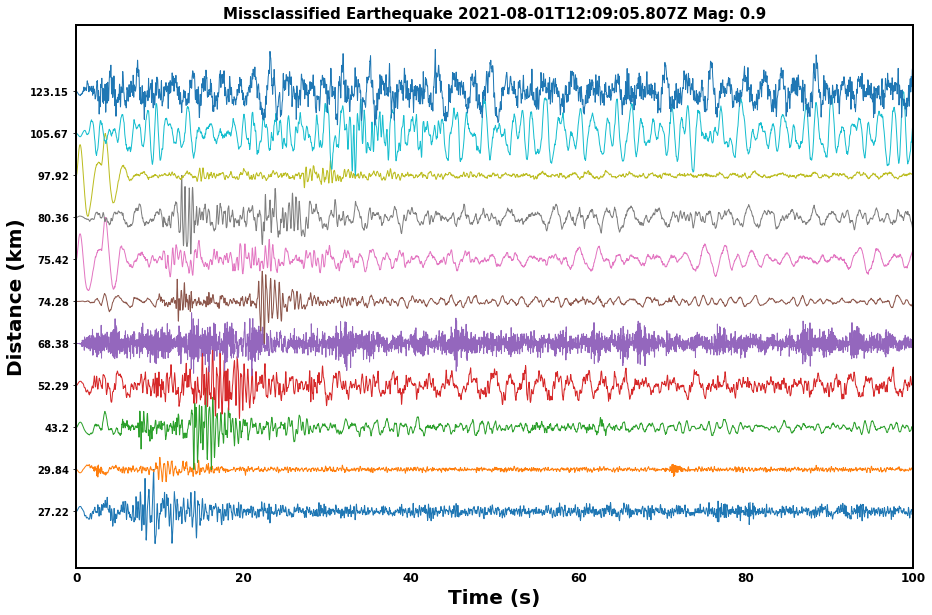

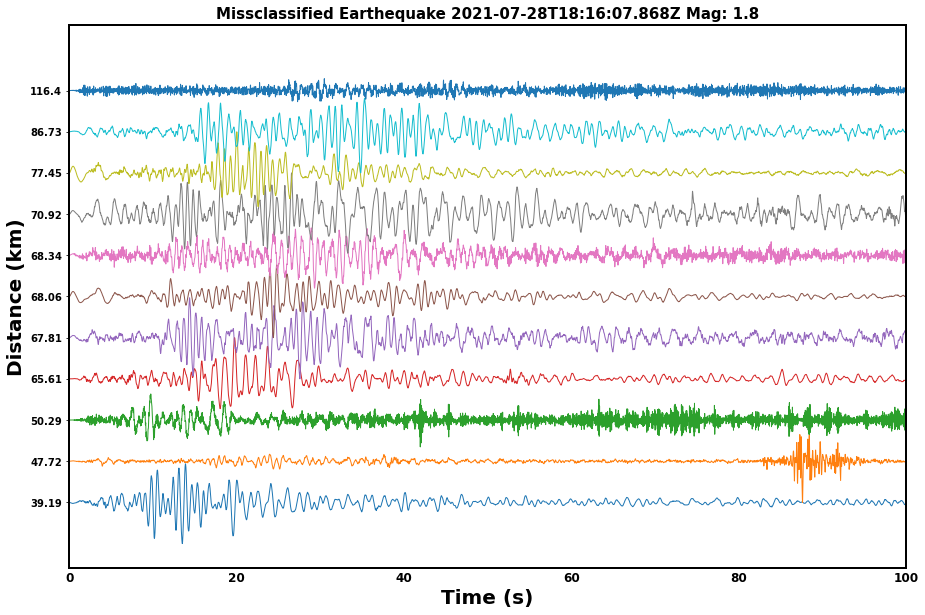

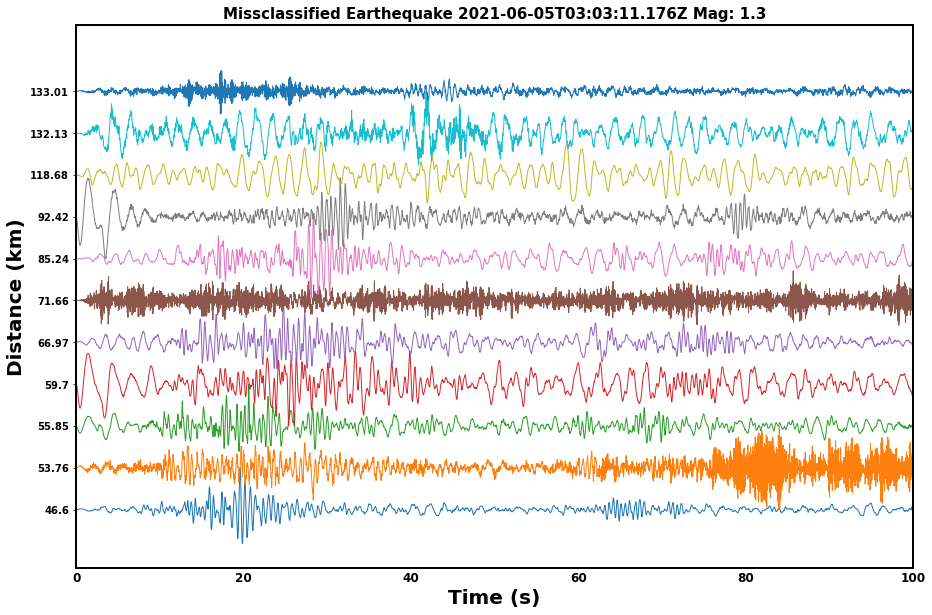

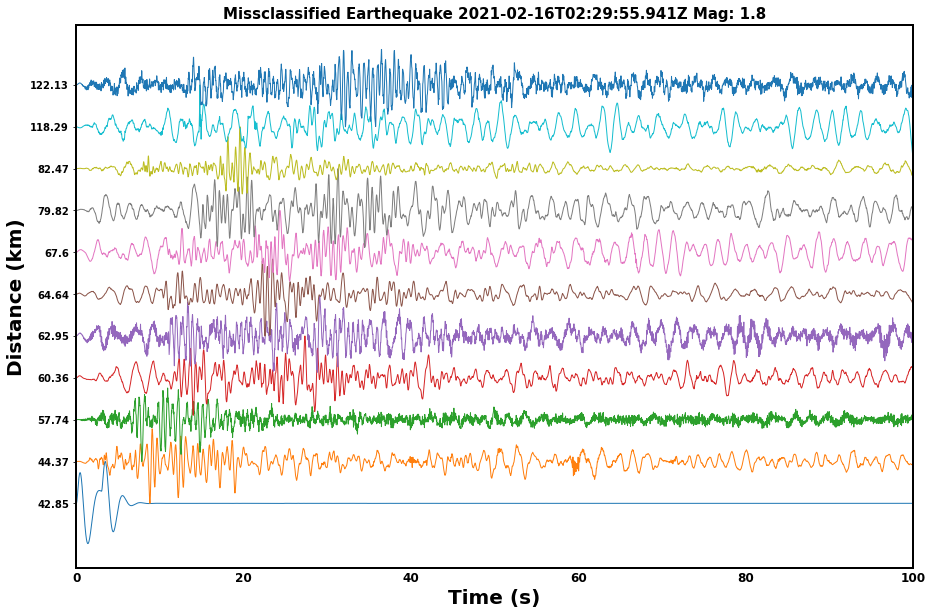

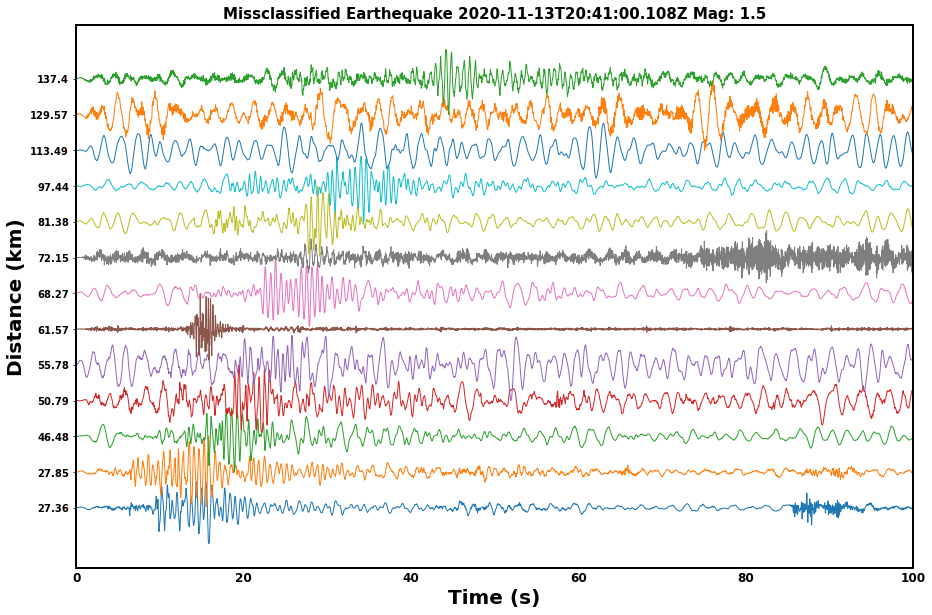

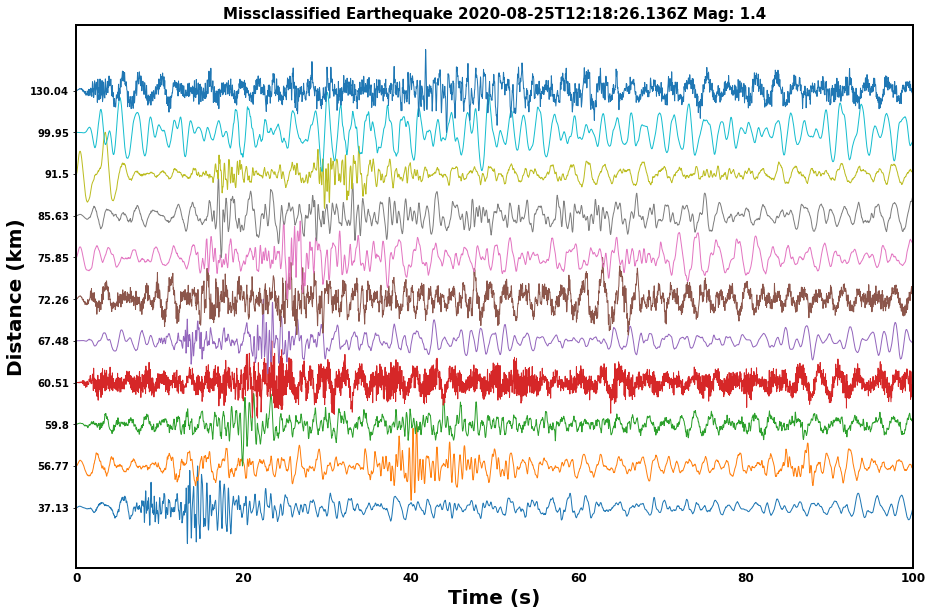

In [126]:
for eq_index in miss_eq_index:
    plt.figure(figsize = [15,10])
    

    stn_w_wf = []

    wf_files =  glob('../Data/earthquake_waveforms/earthquake_'+str(eq_index)+'_*')

    for j in range(len(wf_files)):
        stn_w_wf.append(wf_files[j].split('_')[-1].split('.')[0])


    dist = []
    for k in range(len(stn_w_wf)):
        dist.append(compute_epi_dist(index = eq_index, station = stn_w_wf[k]))

    dist_order = np.argsort(dist)     
    print(dist)
    for i in range(len(dist_order)):
            
       
        
        
        
        st = obspy.read(glob('../Data/earthquake_waveforms/earthquake_'+str(eq_index)+'_*')[dist_order[i]])[2]
        st.taper(0.01)
        st.detrend()
        st.filter('bandpass', freqmin = 0.5, freqmax = 10)

        d = st.data/np.max(abs(st.data))
        t = st.times()



        plt.plot(t,d+i, lw = 1)

        plt.xlim(0,100)


        plt.title('Missclassified Earthequake '+earthquakes.iloc[eq_index].time + ' Mag: '+str(np.around(earthquakes.iloc[eq_index].mag,2))
                 , fontsize = 15, fontweight = 'bold')
        plt.ylabel('Distance (km)', fontsize = 20, fontweight = 'bold')
        plt.xlabel('Time (s)', fontsize = 20, fontweight = 'bold')
        plt.yticks(ticks = np.arange(len(dist_order)),labels = [str(np.around(di,2)) for di in np.array(dist)[dist_order]])

In [127]:
miss_eq_index

array([ 565,  575,  666,  883, 1025, 1204])

[132.13038918669207, 85.23691495085157, 55.845526806077224, 118.67927201470073, 92.42446030350582, 46.604958087626855, 53.75508799038006, 133.00534062057, 66.97159530309433, 59.69712535436867, 71.66427993043011]


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9

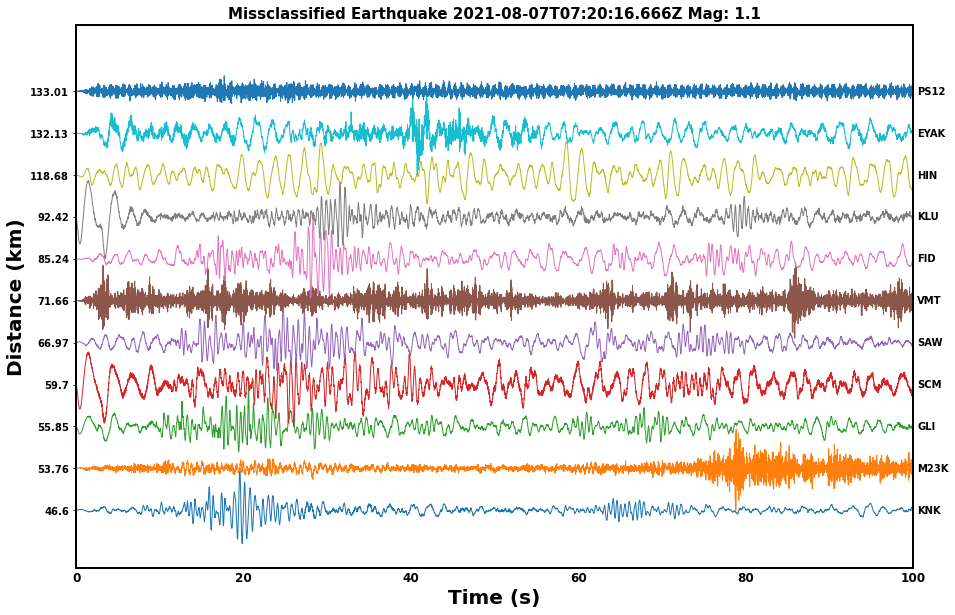

In [138]:
temp_stn = []



stn_w_wf = []
eq_index = 666
wf_files =  glob('../Data/earthquake_waveforms/earthquake_'+str(eq_index)+'_*')

for j in range(len(wf_files)):
    stn_w_wf.append(wf_files[j].split('_')[-1].split('.')[0])


dist = []
for k in range(len(stn_w_wf)):
    dist.append(compute_epi_dist(index = eq_index, station = stn_w_wf[k]))

dist_order = np.argsort(dist)     
print(dist)

    
plt.figure(figsize=[15, 10])
for i in range(len(dist_order)):
    st = obspy.read(glob('../Data/earthquake_waveforms/earthquake_666_*')[dist_order[i]])[2]
    temp_stn.append(glob('../Data/earthquake_waveforms/earthquake_666_*')[dist_order[i]].split('_')[-1].split('.')[0])
    st.taper(0.01)
    st.detrend()
    st.filter('bandpass', freqmin=0.5, freqmax=25)

    d = st.data / np.max(abs(st.data))
    t = st.times()

    plt.plot(t, d + i, lw=1)

    plt.xlim(0, 100)

# Add labels on the right-hand side of the y-axis
plt.yticks(ticks=np.arange(len(dist_order)),
           labels=[str(np.around(i, 2)) for i in np.array(dist)[dist_order]])
for i, label in enumerate(temp_stn):
    plt.text(100.5, i, label, ha='left', va='center', fontsize=10)

plt.title('Missclassified Earthquake ' + icequakes.iloc[150].time + ' Mag: ' + str(np.around(icequakes.iloc[150].mag, 2)),
          fontsize=15, fontweight='bold')
plt.ylabel('Distance (km)', fontsize=20, fontweight='bold')
plt.xlabel('Time (s)', fontsize=20, fontweight='bold')
plt.show()


In [132]:
temp_stn

['KNK',
 'M23K',
 'GLI',
 'SCM',
 'SAW',
 'VMT',
 'FID',
 'KLU',
 'HIN',
 'EYAK',
 'PS12']

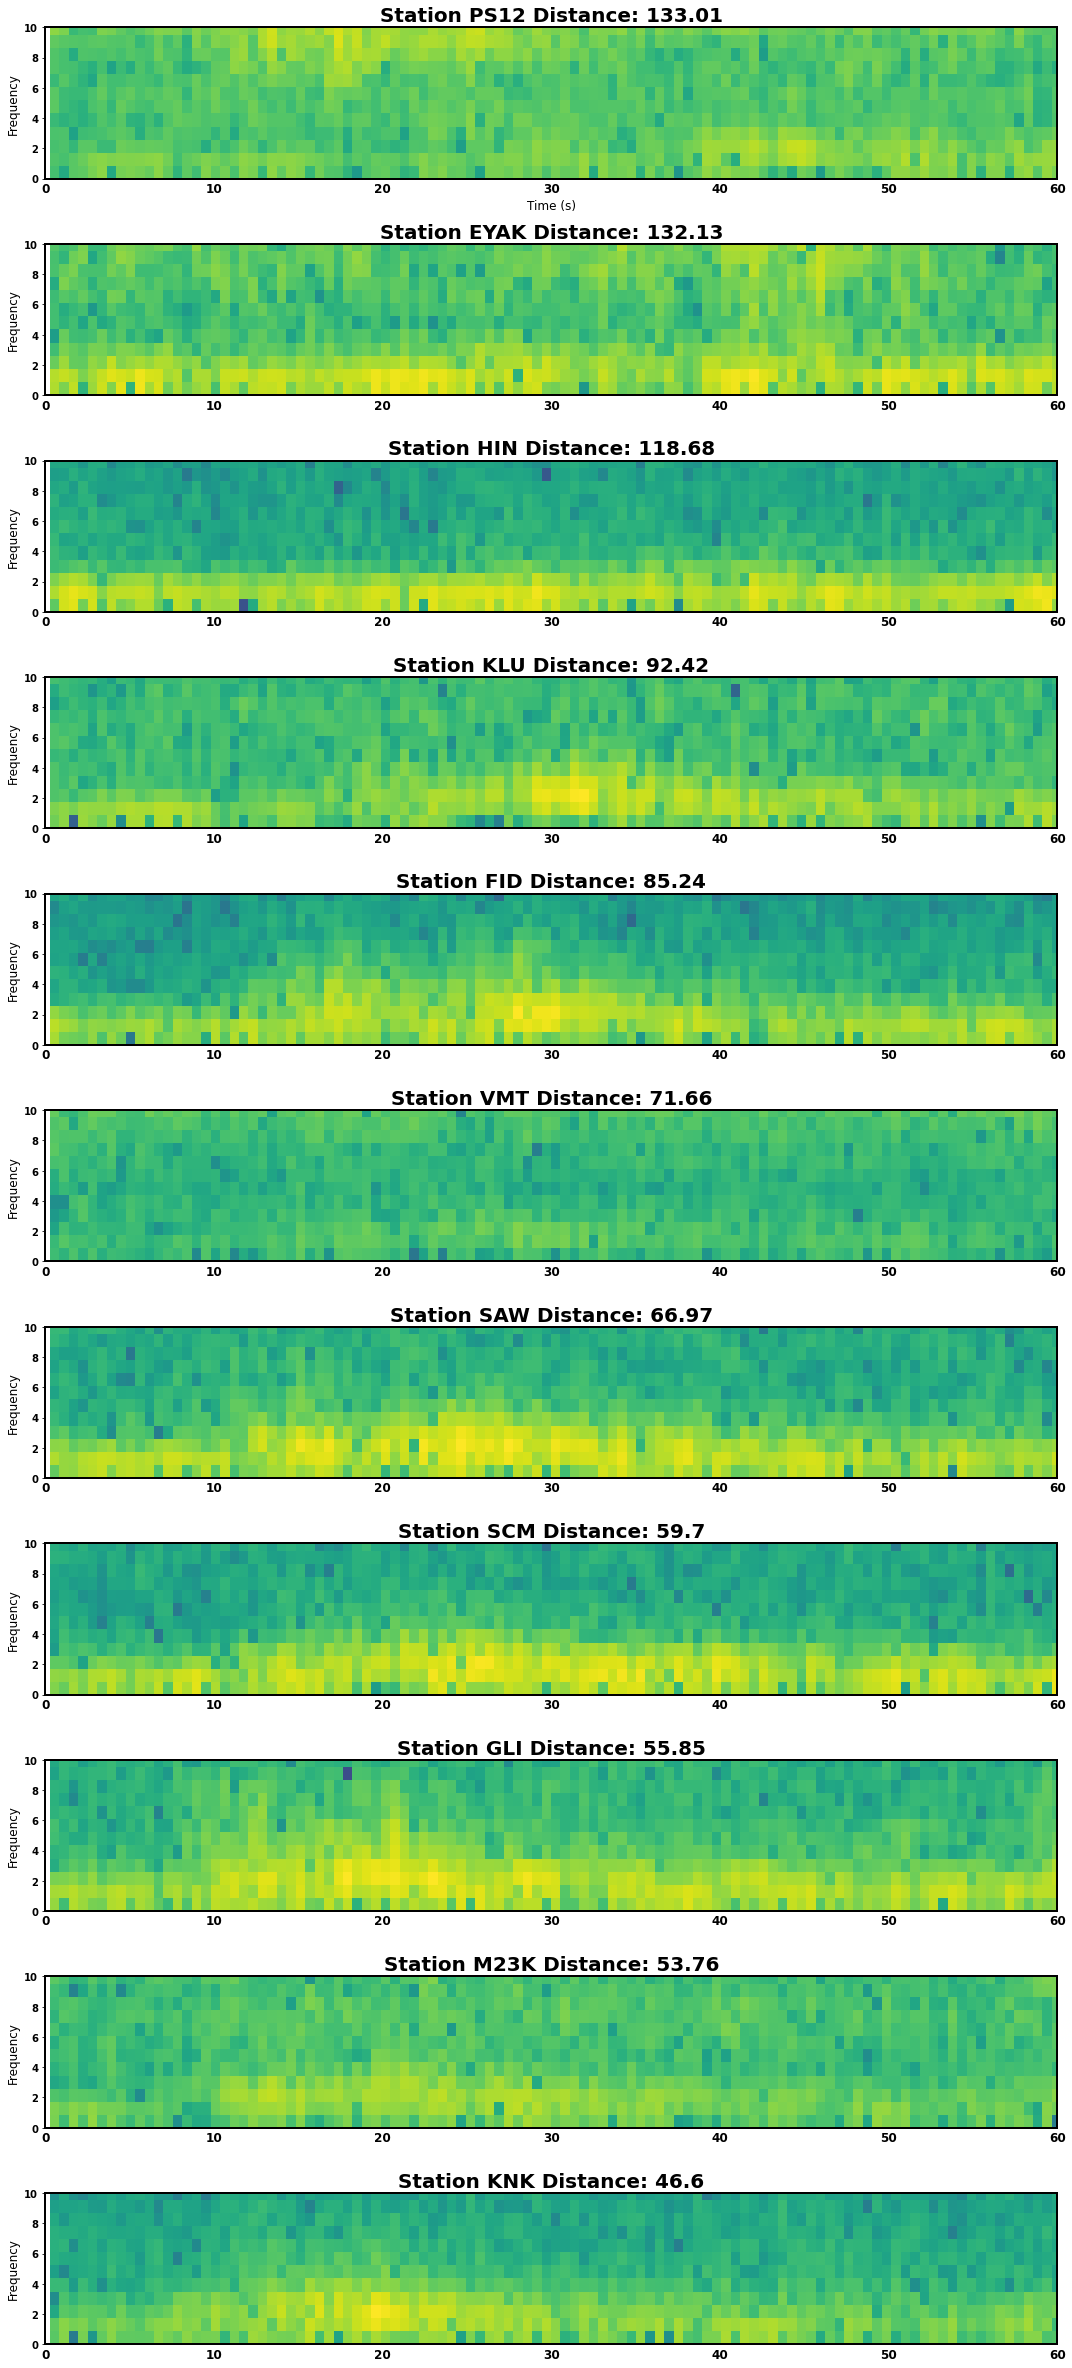

In [141]:
temp_stn = []
fig, axes = plt.subplots(len(dist_order), 1, figsize=(15, 3*len(dist_order)))

axes = axes[::-1]
for i in range(len(dist_order)):
    st = obspy.read(glob('../Data/earthquake_waveforms/earthquake_666_*')[dist_order[i]])[2]
    temp_stn.append(glob('../Data/earthquake_waveforms/earthquake_666_*')[dist_order[i]].split('_')[-1].split('.')[0])
    
    st.detrend()
    st.filter('bandpass', freqmin=0.5, freqmax=25)

    d = st.data / np.max(abs(st.data))
    t = st.times()

    # Plot spectrogram in a separate subplot
    ax = axes[i]
    ax.specgram(d, Fs=50, NFFT= 56, noverlap=  28, cmap='viridis', aspect='auto')

    # Set y-axis label for each subplot
    ax.set_ylabel('Frequency', fontsize=12)
    #ax.set_yticks([i])
    #ax.set_yticklabels([str(np.around(np.array(dist)[dist_order][i], 2))])

    # Set title for each subplot
    ax.set_title('Station ' + temp_stn[i]+' Distance: '+str(np.around(np.array(dist)[dist_order][i], 2)), fontsize=20, fontweight = 'bold')

    ax.set_xlim(0,60)
    ax.set_ylim(0,10)
# Set common x-axis label
axes[-1].set_xlabel('Time (s)', fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
